# 이진 분류 후 Multiclassification

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import optuna
from optuna.samplers import TPESampler
# from optuna.integration import CatBoostPruningCallback

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier
# from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)

## 1. 데이터 불러오기

In [2]:
def get_local_path(train_dataset_name, val_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    val_path = os.path.join(os.getcwd(), "fog_data", val_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        val_path = val_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, val_path, test_path

In [3]:
# 전처리 중간에 nan 제거해주고 이상치 처리한 데이터프레임
train_path, val_path, test_path = get_local_path(
    # "fog_train_merged_std.csv",
    # "fog_val_merged_std.csv",
    # "fog_test_merged_std.csv"
    "fog_train_merged_month_stn_std.csv",
    "fog_val_merged_month_stn_std.csv",
    "fog_test_merged_month_stn_std.csv"
    )

In [4]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

## 2. Preprocessing

### 2-1. 결측치 처리

In [5]:
# train, val, test 데이터셋에서 -99, -99.9 포함한 컬럼 확인
train_cols_na = train_df.columns[train_df.isna().any()].tolist()
val_cols_na = val_df.columns[val_df.isna().any()].tolist()
test_cols_na = test_df.columns[test_df.isna().any()].tolist()

In [6]:
# 결측치 대체 함수
def fill_missing_values_with_monthly_mean(df, na_columns):

    df_filled = df.copy()

    # month, stn_id로 groupby 한 후 na_columns별로 각각 평균을 구한다
    grouped_means = df.groupby(['month', 'stn_id'])[na_columns].transform('mean')

    # na_columns별 결측치를 각 컬럼들의 평균로 대체한다
    for column in na_columns:
        df_filled[column] = df_filled[column].fillna(grouped_means[column])

    return df_filled

In [7]:
# 결측치 대체 처리 (month, stn_id별 각 컬럼의 평균으로 대체)
train_df = fill_missing_values_with_monthly_mean(train_df, train_cols_na)
val_df = fill_missing_values_with_monthly_mean(val_df, val_cols_na)
test_df = fill_missing_values_with_monthly_mean(test_df, test_cols_na)

### 2-2. train, val, test 데이터셋 분리

In [8]:
# 이진 분류시 사용할 train, validation, test 데이터셋 선언

# target 컬럼
target_binary = "is_fog"

# 모델 생성시 사용할 컬럼 선택
used_cols_binary = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm",
                    "re", "ws10_ms", "sun10", "dew_reached", "t_td", "ws10_deg"]

X_train_binary = train_df[used_cols_binary]
y_train_binary = train_df[target_binary]

X_val_binary = val_df[used_cols_binary]
y_val_binary = val_df[target_binary]

X_test_binary = test_df[used_cols_binary]

In [9]:
# 이진 분류 이후, multiclassification에 사용할 컬럼 지정

# target 컬럼
target_multiclassification = "class"

# 모델 생성시 사용할 컬럼 지정
used_cols_multiclassification = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm",
                                 "re", "ws10_ms", "sun10", "dew_reached",  "t_td", "ws10_deg"]


X_train_mc = train_df[used_cols_multiclassification]
y_train_mc = train_df[target_multiclassification]

X_val_mc = val_df[used_cols_multiclassification]
y_val_mc = val_df[target_multiclassification]

X_test_mc = test_df[used_cols_multiclassification]

In [10]:
X_train_binary.shape, X_val_binary.shape, y_train_binary.shape, y_val_binary.shape, X_test_binary.shape

((2350456, 13), (783486, 13), (2350456,), (783486,), (262800, 13))

In [11]:
X_train_mc.shape, X_val_mc.shape, y_train_mc.shape, y_val_mc.shape, X_test_mc.shape

((2350456, 13), (783486, 13), (2350456,), (783486,), (262800, 13))

### 2-3. CSI Index 생성

In [12]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):

    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] +
            model_cm[1][0] + model_cm[1][2] +
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

### 2-4. Label Encoding

In [13]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

# stn_id_map을 바탕으로 stn_id 컬럼 mapping
X_train_binary["stn_id"] = X_train_binary["stn_id"].map(stn_id_map)
X_val_binary["stn_id"] = X_val_binary["stn_id"].map(stn_id_map)
X_test_binary["stn_id"] = X_test_binary["stn_id"].map(stn_id_map)

In [14]:
# stn_id_map을 바탕으로 stn_id 컬럼 mapping
X_train_mc["stn_id"] = X_train_mc["stn_id"].map(stn_id_map)
X_val_mc["stn_id"] = X_val_mc["stn_id"].map(stn_id_map)
X_test_mc["stn_id"] = X_test_mc["stn_id"].map(stn_id_map)

## 3. 모델링

#### 3-1. 이진 분류 모델

In [15]:
def binary_rf(X_train_binary, y_train_binary, X_val_binary, y_val_binary, X_test_binary):
    stn_list = range(1, 6)

    # X_val_binary 데이터셋을 stn_id에 맞게 정렬
    X_val_binary_sorted = X_val_binary.sort_values('stn_id')
    y_val_binary_sorted = y_val_binary.loc[X_val_binary_sorted.index]

    # X_train_binary, X_val_binary, X_test_binary index로 된 Series 선언
    y_train_pred_df = pd.Series(index=X_train_binary.index, dtype=float)
    y_val_pred_df = pd.Series(index=X_val_binary.index, dtype=float)
    y_test_pred_df = pd.Series(index=X_test_binary.index, dtype=float)

    # Random Forest 분류 모델 생성
    models = {i: RandomForestClassifier(max_features="sqrt", 
                                        # class_weight="balanced",
                                        max_depth=50,
                                        random_state=42) for i in stn_list}

    cm_binary = {}

    # 관측소별 for 문
    for i in stn_list:
        # 관측소 별로 해당하는 index를 train_binary 데이터에서 뽑아온다
        now_idx_train = X_train_binary[X_train_binary['stn_id'] == i].index
        now_idx_val = X_val_binary_sorted[X_val_binary_sorted['stn_id'] == i].index
        now_idx_test = X_test_binary[X_test_binary['stn_id'] == i].index

        # 관측소별 index에 해당하는 X_train_binary, y_train_binary 데이터로 모델 학습
        models[i].fit(X_train_binary.loc[now_idx_train], y_train_binary.loc[now_idx_train])

        # 관측소별 index에 맞게 학습한 모델로 y_train, y_val, y_test 예측한 값 선언
        y_train_pred_now = models[i].predict(X_train_binary.loc[now_idx_train])
        y_val_pred_now = models[i].predict(X_val_binary_sorted.loc[now_idx_val])
        y_test_pred_now = models[i].predict(X_test_binary.loc[now_idx_test])

        # 값이 비어있는 Series에 모델로 예측한 값을 index에 맞게 채워 넣는다
        y_train_pred_df.loc[now_idx_train] = y_train_pred_now
        y_val_pred_df.loc[now_idx_val] = y_val_pred_now
        y_test_pred_df.loc[now_idx_test] = y_test_pred_now

        # confusion matrix 생성
        cm_binary[i] = confusion_matrix(y_val_binary_sorted[now_idx_val], y_val_pred_now)


    return y_train_pred_df, y_val_pred_df, y_test_pred_df, cm_binary

In [16]:
y_train_pred_rf, y_val_pred_rf, y_test_pred_rf, cm_binary = binary_rf(X_train_binary, y_train_binary, X_val_binary, y_val_binary, X_test_binary)

In [18]:
# 관측소별 이진분류 confusion matrix 확인
cm_binary

{1: array([[310839,     91],
        [  1116,    517]], dtype=int64),
 2: array([[153040,    289],
        [  1450,   2025]], dtype=int64),
 3: array([[78053,     9],
        [  333,   109]], dtype=int64),
 4: array([[115782,     80],
        [   899,    855]], dtype=int64),
 5: array([[117229,     40],
        [   340,    390]], dtype=int64)}

In [19]:
# train 데이터 기준 이진 분류 예측 confusion matrix
confusion_matrix(y_train_binary, y_train_pred_rf)

array([[2326345,      11],
       [     37,   24063]], dtype=int64)

In [20]:
# validation 데이터 기준 이진 분류 예측 confusion matrix
confusion_matrix(y_val_binary, y_val_pred_rf)

array([[774943,    509],
       [  4138,   3896]], dtype=int64)

In [21]:
# test 데이터 기준 이진 분류 예측 결과
y_test_pred_rf.value_counts()

0.0    261734
1.0      1066
Name: count, dtype: int64

In [22]:
# pickle 저장

# 이진 분류 결과 save
with open('y_train_pred_rf_tuned.pickle', 'wb') as f:
    pickle.dump(y_train_pred_rf, f)

with open('y_val_pred_rf_tuned.pickle', 'wb') as f:
    pickle.dump(y_val_pred_rf, f)

with open('y_test_pred_rf_tuned.pickle', 'wb') as f:
    pickle.dump(y_test_pred_rf, f)

# confusion matrix 저장
with open('cm_binary_tuned.pickle', 'wb') as f:
    pickle.dump(cm_binary, f)

In [42]:
# # load
# with open('y_train_pred_rf.pickle', 'rb') as f:
#     y_pred_t = pickle.load(f)

# # load
# with open('y_val_pred_rf.pickle', 'rb') as f:
#     y_pred_v = pickle.load(f)

# # load
# with open('y_test_pred_rf.pickle', 'rb') as f:
#     y_pred_te = pickle.load(f)

### 3-2. 다중 분류 모델

In [23]:
# 이진 분류의 예측값 (0, 1)이 float로 되어 있어 int로 변경
y_train_pred_rf = y_train_pred_rf.astype("int")
y_val_pred_rf = y_val_pred_rf.astype("int")
y_test_pred_rf = y_test_pred_rf.astype("int")

In [24]:
# 이진 분류 예측값 중, 1로 나온 것들의 index 선언
y_train_pred_rf_idx = y_train_pred_rf[y_train_pred_rf==1].index
y_val_pred_rf_idx = y_val_pred_rf[y_val_pred_rf==1].index
y_test_pred_rf_idx = y_test_pred_rf[y_test_pred_rf==1].index

In [ ]:
# train, val, test 데이터프레임 class_predict 컬럼 drop (컬럼 내용 초기화 목적)
# train_df = train_df.drop(columns="class_predict")
# val_df = val_df.drop(columns="class_predict")
# test_df = test_df.drop(columns="class_predict")

In [26]:
# train, val, test 데이터를 각각 이진 분류로 예측한 값인 is_fog==0으로 나온 index를
# 새롭게 class_predict 컬럼을 생성하여 4(시정 >1000)로 선언
# class_predict 컬럼의 나머지 값들 : NaN 
train_df.loc[y_train_pred_rf[y_train_pred_rf == 0].index, 'class_predict'] = 4

In [32]:
val_df.loc[y_val_pred_rf[y_val_pred_rf == 0].index, 'class_predict'] = 4

In [33]:
test_df.loc[y_test_pred_rf[y_test_pred_rf == 0].index, 'class_predict'] = 4

In [36]:
# 이진 분류 후, is_fog==1 인 데이터의 multiclassification을 통해 class 컬럼을 예측해야 한다
# X_train에서 실제로 안개가 낀 값 (is_fog==1)만 필터링하여 다중 분류의 train 값으로 선언

X_train_cl = X_train_binary[y_train_binary == 1]
y_train_cl = y_train_mc[y_train_binary == 1]

In [37]:
# 이진 분류 예측값 중, 1로 나온 것들의 index를 다시 원본 X_val, X_test 데이터프레임에 필터링
# 다중 분류의 예측값으로 사용

X_val_cl = X_val_binary.loc[y_val_pred_rf_idx]
y_val_cl = y_val_mc.loc[y_val_pred_rf_idx]

X_test_cl = X_test_binary.loc[y_test_pred_rf_idx]

In [50]:
def class_rf_stn(X_train_cl, y_train_cl, X_val_cl, y_val_cl, X_test_cl):
    stn_list = range(1, 6)
    cm_cl = {}

    X_val_cl_sorted = X_val_cl.sort_values('stn_id')
    y_val_cl_sorted = y_val_cl.loc[X_val_cl_sorted.index]

    y_train_pred_df = pd.Series(index=X_train_cl.index, dtype=int)
    y_val_pred_df = pd.Series(index=X_val_cl.index, dtype=int)
    y_test_pred_df = pd.Series(index=X_test_cl.index, dtype=int)

    models = {i: RandomForestClassifier(random_state=42) for i in stn_list}

    for i in stn_list:
        # train
        now_idx_train = X_train_cl[X_train_cl['stn_id'] == i].index
        
        models[i].fit(X_train_cl.loc[now_idx_train], y_train_cl.loc[now_idx_train])
        y_train_pred_now = models[i].predict(X_train_cl.loc[now_idx_train])
        y_train_pred_df.loc[now_idx_train] = y_train_pred_now
        
        # validataion
        now_idx_val = X_val_cl_sorted[X_val_cl_sorted['stn_id'] == i].index
        y_val_pred_now = models[i].predict(X_val_cl_sorted.loc[now_idx_val])
        y_val_pred_df.loc[now_idx_val] = y_val_pred_now

        # test
        now_idx_test = X_test_cl[X_test_cl['stn_id'] == i].index
        if list(now_idx_test) == []:
            print(f"stn_id : {i}에 해당하는 값이 test 데이터셋에 없음")
            continue
        y_test_pred_now = models[i].predict(X_test_cl.loc[now_idx_test])
        y_test_pred_df.loc[now_idx_test] = y_test_pred_now

        # confusion matrix 생성
        cm_cl[i] = confusion_matrix(y_val_cl_sorted[now_idx_val], y_val_pred_now)
        
    return y_train_pred_df, y_val_pred_df, y_test_pred_df, cm_cl

In [51]:
y_train_pred_cl, y_val_pred_cl, y_test_pred_cl, cm_cl = class_rf_stn(X_train_cl, y_train_cl, X_val_cl, y_val_cl, X_test_cl)

stn_id : 3에 해당하는 값이 test 데이터셋에 없음
stn_id : 5에 해당하는 값이 test 데이터셋에 없음


In [59]:
train_df.loc[y_train_pred_cl.index, 'class_predict'] = y_train_pred_cl

In [60]:
val_df.loc[y_val_pred_cl.index, 'class_predict'] = y_val_pred_cl

In [61]:
test_df.loc[y_test_pred_cl.index, 'class_predict'] = y_test_pred_cl

In [62]:
test_df["class_predict"].value_counts().sort_index()

class_predict
1.0        64
2.0       827
3.0       175
4.0    261734
Name: count, dtype: int64

In [63]:
csi_index(val_df["class"], val_df["class_predict"])

0.31862343439072927

In [65]:
cm = confusion_matrix(val_df["class"], val_df["class_predict"])
cm

array([[   948,    332,     24,    663],
       [   246,   1217,    234,   1325],
       [    37,    301,    557,   2150],
       [    58,    201,    250, 774943]], dtype=int64)

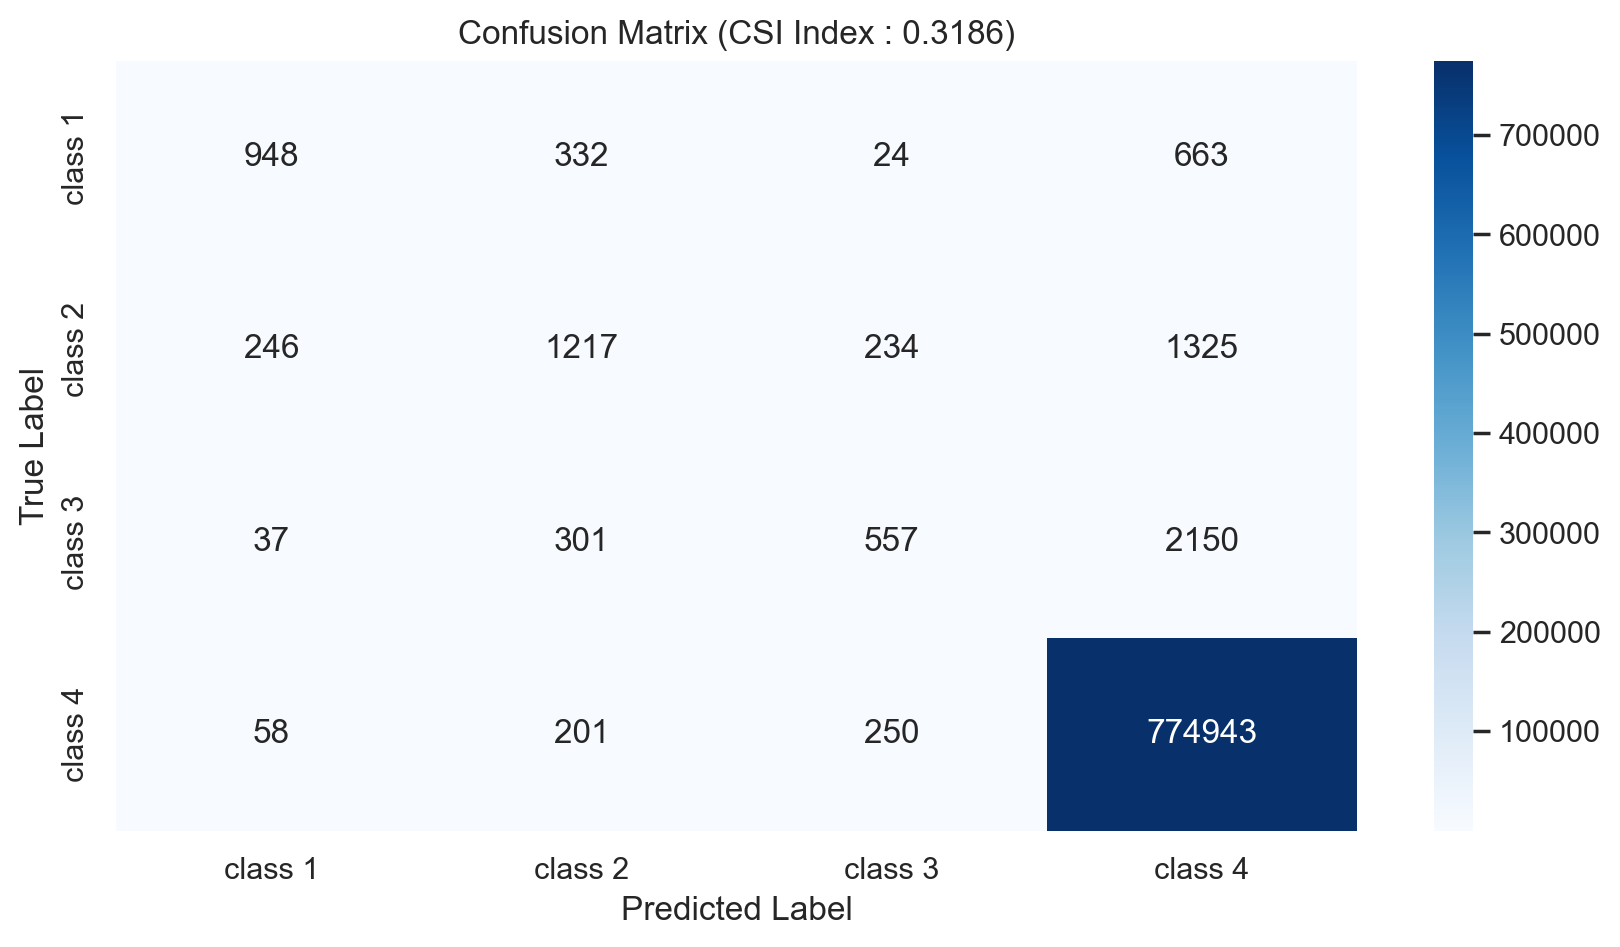

In [67]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(val_df["class_predict"], return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix (CSI Index : {np.round(csi_index(val_df["class"], val_df["class_predict"]), 4)})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [68]:
test_df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,is_fog,dew_point,dew_reached,temp_diff,ws10_dir,t_td,class_predict
0,L,1,1,0,0,A,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,1,-4.223642,0,-0.9,NW,1.723642,4.0
1,L,1,1,0,10,A,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,1,-4.121508,0,-0.9,NW,1.621508,4.0
2,L,1,1,0,20,A,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,1,-4.063468,0,-0.8,N,1.563468,4.0
3,L,1,1,0,30,A,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,1,-4.147662,0,-1.0,NW,1.547662,4.0
4,L,1,1,0,40,A,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,1,-4.104366,0,-1.0,SW,1.504366,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,L,12,31,23,10,E,338.8,6.1,4.5,0.0,71.3,0.0,1.9,1,-0.079539,0,2.6,N,4.579539,4.0
262796,L,12,31,23,20,E,335.2,5.8,4.6,0.0,71.4,0.0,1.9,1,0.035285,0,2.7,NW,4.564715,4.0
262797,L,12,31,23,30,E,337.1,5.3,4.5,0.0,72.1,0.0,1.8,1,0.068708,0,2.7,NW,4.431292,4.0
262798,L,12,31,23,40,E,322.0,3.7,4.3,0.0,72.5,0.0,1.4,1,-0.050479,0,2.9,NW,4.350479,4.0


In [70]:
# 예측한 test_df 저장
test_df.to_csv("data/test_df.csv")

In [100]:
# stn_id별로 모델 X

def class_rf(X_train_cl, y_train_cl, X_val_cl, y_val_cl, X_test_cl):
    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(random_state=42)

    # train_cl 데이터셋을 모델에 fitting
    model.fit(X_train_cl, y_train_cl)

    # 모델을 바탕으로 train_cl 데이터셋을 활용하여 y_train 값을 분류
    y_train_pred = model.predict(X_train_cl)
    
    # 모델을 바탕으로 val_cl 데이터셋을 활용하여 y_val 값을 분류
    y_val_pred = model.predict(X_val_cl)
    
    # 모델을 바탕으로 test_cl 데이터셋을 활용하여 y_val 값을 분류
    y_test_pred = model.predict(X_test_cl)

    # 원본 인덱스에 맞게, 분류한 값 (class)를 각각 Series로 선언
    y_train_pred_df = pd.Series(y_train_pred, index=X_train_cl.index)
    y_val_pred_df = pd.Series(y_val_pred, index=X_val_cl.index)
    y_test_pred_df = pd.Series(y_test_pred, index=X_test_cl.index)

    cm_multiclassification = confusion_matrix(y_val_cl, y_val_pred_df)

    return y_train_pred_df, y_val_pred_df, y_test_pred_df, cm_multiclassification